In [ ]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !git clone https://github.com/dmhd1/mcproject.git
    %cd mcproject/
    %mkdir data/
    !pip install torch torchvision
else:
    print('Not running on CoLab')

In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.tensorboard import SummaryWriter
import yaml
import matplotlib.pyplot as plt
import numpy as np
from lib.models import vae as vae

In [3]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
class DictAsMember(dict):
    def __getattr__(self, name):
        value = self[name]
        if isinstance(value, dict):
            value = DictAsMember(value)
        return value

In [5]:
options = """
batch_size: 128
epochs: 10
cuda: False
seed: 1
log_interval: 100
result_folder: './runs'
data_folder: '../data'
"""

In [6]:
args = DictAsMember(yaml.safe_load(options))
args.cuda = args.cuda and torch.cuda.is_available()

In [7]:
writer = SummaryWriter(f'{args.result_folder}/tb')

In [8]:
torch.manual_seed(args.seed);

Set up device:

In [9]:
device = torch.device("cuda:0" if args.cuda else 'cpu' )
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

Load data:

In [10]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(args.data_folder, train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(args.data_folder, train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

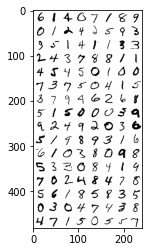

In [11]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
writer.add_image('mnist_images', img_grid)

In [12]:
model = vae.VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_function = vae.loss_function

In [13]:
torch.jit.check_trace = False
writer.add_graph(model, images.to(device))

/home/dm/anaconda3/envs/mc/lib/python3.8/site-packages/torch/jit/_trace.py:958: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(128:20, 20:1, requires_grad=0, device=cpu) = aten::randn_like(%std, %43, %44, %45, %46, %47) # /home/dm/projects/pytorch/mcproject/lib/models/vae.py:24:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/dm/anaconda3/envs/mc/lib/python3.8/site-packages/torch/jit/_trace.py:958: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 100335 element(s) (out of 100352) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 0.3377220630645752 (0.3113430142402649 vs. 0.6490650773048401), which occurred at index (50, 545).
  _check_trace(


In [14]:
if 'google.colab' in str(get_ipython()):
    %load_ext
    !tensorboard --logdir=./runs/
else:
    print('Run tensorboard on your local machine.')

Run tensorboard on your local machine.


### Training

In [15]:
for epoch in range(1, args.epochs + 1):
    vae.train(model, epoch, optimizer, train_loader, loss_function, device, args, writer=writer)
    vae.test(model, epoch, test_loader, loss_function, device, args, writer=writer)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28), f'{args.result_folder}/{epoch}.png')

KeyboardInterrupt: 